In [57]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from skimage.transform import rescale
import scipy.ndimage as ndimage
from scipy.ndimage import map_coordinates


In [58]:
phantom = shepp_logan_phantom()
phantom = resize(phantom, (128, 128), mode='reflect', anti_aliasing=True)

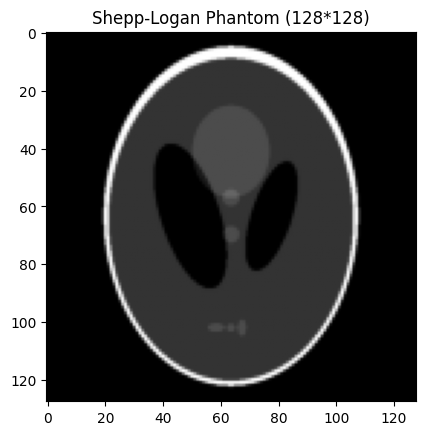

In [71]:
plt.imshow(phantom, cmap='gray')
plt.title('Shepp-Logan Phantom (128*128)')
plt.show()

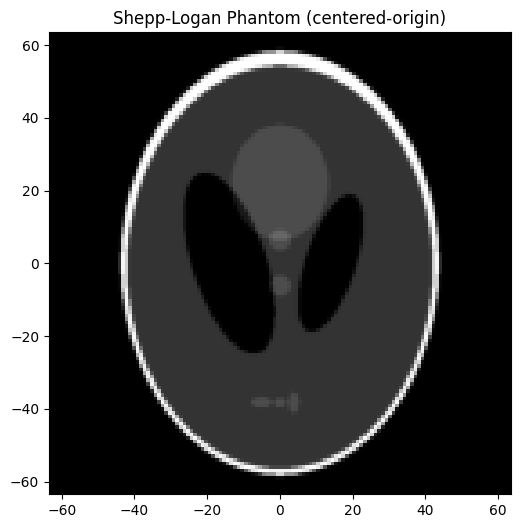

In [72]:
plt.figure(figsize=(6, 6))
extent = [-(phantom.shape[1]-1)/2, (phantom.shape[1]-1)/2,
          -(phantom.shape[0]-1)/2, (phantom.shape[0]-1)/2]
plt.imshow(phantom, cmap='gray', extent=extent)
plt.title('Shepp-Logan Phantom (centered-origin)')
plt.show()

(a)

In [61]:
def myXrayIntegration(f, t, theta, del_s=0.5):

    theta_rad = np.deg2rad(theta)

    N, M = f.shape  
    center_x = (M-1) / 2.0
    center_y = (N-1) / 2.0

    s_max = np.sqrt(center_x**2 + center_y**2)
    s = s_max * np.sqrt(2)
    s_values = np.arange(-s, s + del_s, del_s)

    x = t * np.cos(theta_rad) - s_values * np.sin(theta_rad)
    y = t * np.sin(theta_rad) + s_values * np.cos(theta_rad)

    cols = x + center_x
    rows = center_y - y

    coords = np.vstack((rows, cols))

    line_values = map_coordinates(f, coords, order=1, mode='constant', cval=0.0)

    integral = np.sum(line_values) * del_s
    
    return integral


<b>Justification for choosing $\Delta$ s = 0.5:</b> <br>
As the image has a pixel spacing of 1 unit, choosing $\Delta$ s = 0.5 (that can be said as sampling twice per pixel) seems a good choice managing both accuracy and computational cost. On increasing the $\Delta$ s, it may fail to capture variations in image intensity, while decreasing it can burden the computation. <br>
<br>
<b>Justification for choosing Bilinear Interpolation as image interpretation scheme:</b> <br>
Bilinear Interpolation is used because it is easy to implement and also gives a good balance between computational efficiceny and accuracy. It also provides a continuous, smooth approximation of the image intensity between pixel centers by taking weighted average of neighbouring pixels.

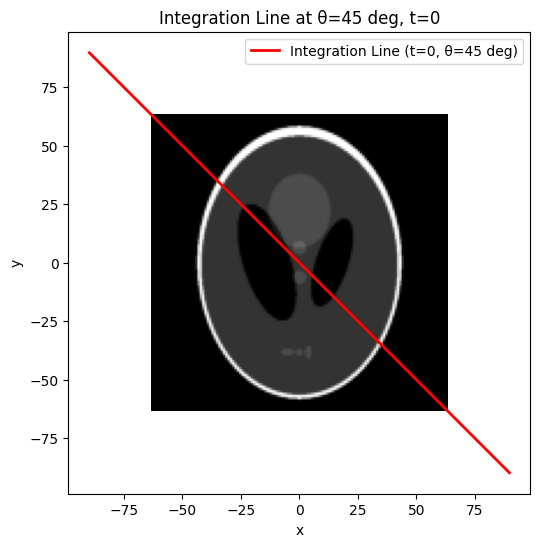

In [62]:
def plot_integration_line(f, t, theta, del_s=0.5):

    theta_rad = np.deg2rad(theta)
    
    N, M = f.shape
    center_x = (M - 1) / 2.0
    center_y = (N - 1) / 2.0
    
    s_max = np.sqrt(center_x**2 + center_y**2)
    s = s_max * np.sqrt(2)
    s_values = np.linspace(-s, s, 100)

    x = t * np.cos(theta_rad) - s_values * np.sin(theta_rad)
    y = t * np.sin(theta_rad) + s_values * np.cos(theta_rad)

    plt.figure(figsize=(6, 6))
    plt.imshow(f, cmap='gray', extent=[-center_x, center_x, -center_y, center_y])
    
    plt.plot(x, y, 'r-', linewidth=2, label=f'Integration Line (t={t}, θ={theta} deg)')
    
    plt.title(f'Integration Line at θ={theta} deg, t={t}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Example visualization
plot_integration_line(phantom, t=0, theta=45, del_s=0.5)


(b)

In [63]:
def myXrayCTRadonTransform(f, integration_step=0.5):

    t_values = np.arange(-90, 91, 5)
    theta_values = np.arange(0, 180, 5)
    
    radon_transform = np.zeros((len(t_values), len(theta_values)))
    
    for i, t in enumerate(t_values):
        for j, theta in enumerate(theta_values):
            radon_transform[i, j] = myXrayIntegration(f, t, theta, del_s=integration_step)
            
    return radon_transform, t_values, theta_values

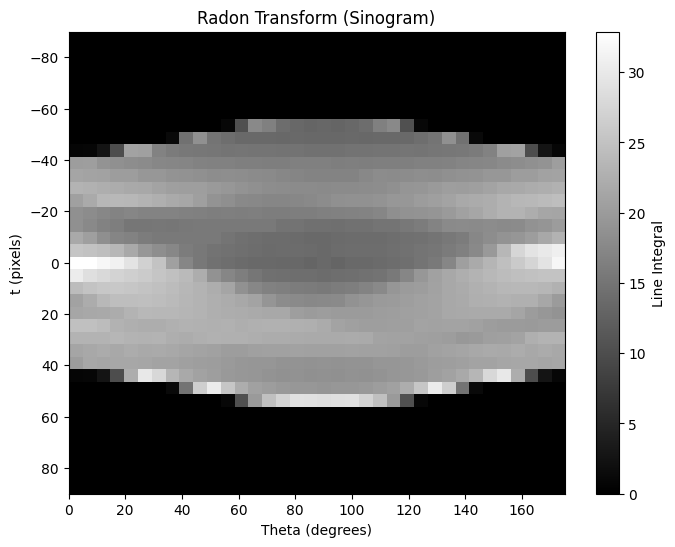

In [64]:
radon_transform, t_vals, theta_vals = myXrayCTRadonTransform(phantom, integration_step=0.5)

plt.figure(figsize=(8, 6))
extent = [theta_vals[0], theta_vals[-1], t_vals[-1], t_vals[0]] 
plt.imshow(radon_transform, cmap='gray', extent=extent, aspect='auto')
plt.xlabel('Theta (degrees)')
plt.ylabel('t (pixels)')
plt.title('Radon Transform (Sinogram)')
plt.colorbar(label='Line Integral')
plt.show()

(c)

In [65]:
delta_s_values = [0.5, 1.0, 3.0]

radon_results = {}

for ds in delta_s_values:
    radon_transform, t_vals, theta_vals = myXrayCTRadonTransform(phantom, integration_step=ds)
    radon_results[ds] = radon_transform
    print(f"Computed Radon transform with del s = {ds}\n{radon_results[ds]}")


Computed Radon transform with del s = 0.5
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Computed Radon transform with del s = 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Computed Radon transform with del s = 3.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


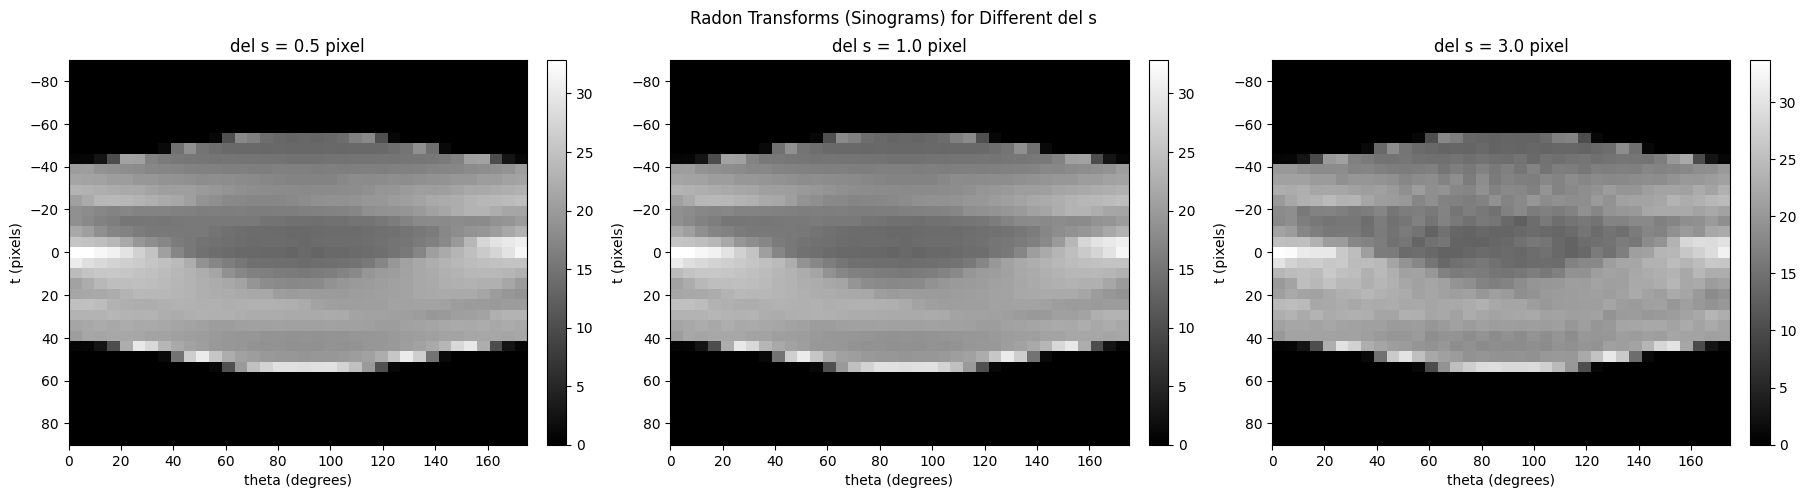

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
extent = [theta_vals[0], theta_vals[-1], t_vals[-1], t_vals[0]] 

for ax, ds in zip(axs, delta_s_values):
    im = ax.imshow(radon_results[ds], cmap='gray', extent=extent, aspect='auto')
    ax.set_title(f"del s = {ds} pixel")
    ax.set_xlabel("theta (degrees)")
    ax.set_ylabel("t (pixels)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Radon Transforms (Sinograms) for Different del s")
plt.show()


<b>Comparison between Radon Transform (Sinogram) Images for different $\Delta$ s values:</b><br>

   - **Smoothest Sinogram:**  
     The Radon transform computed with $\Delta$ s = 0.5 appears the smoothest which is because every projection is integrated with high resolution along the line, thus producing a consistent and smooth sinogram.
     
   - **Roughest Sinogram:**  
     The Radon transform computed with $\Delta$ s = 3 is the roughest which is because of the coarse sampling, which resulted in significant discretization error, which can be observed as irregularities and noise in the sinogram.


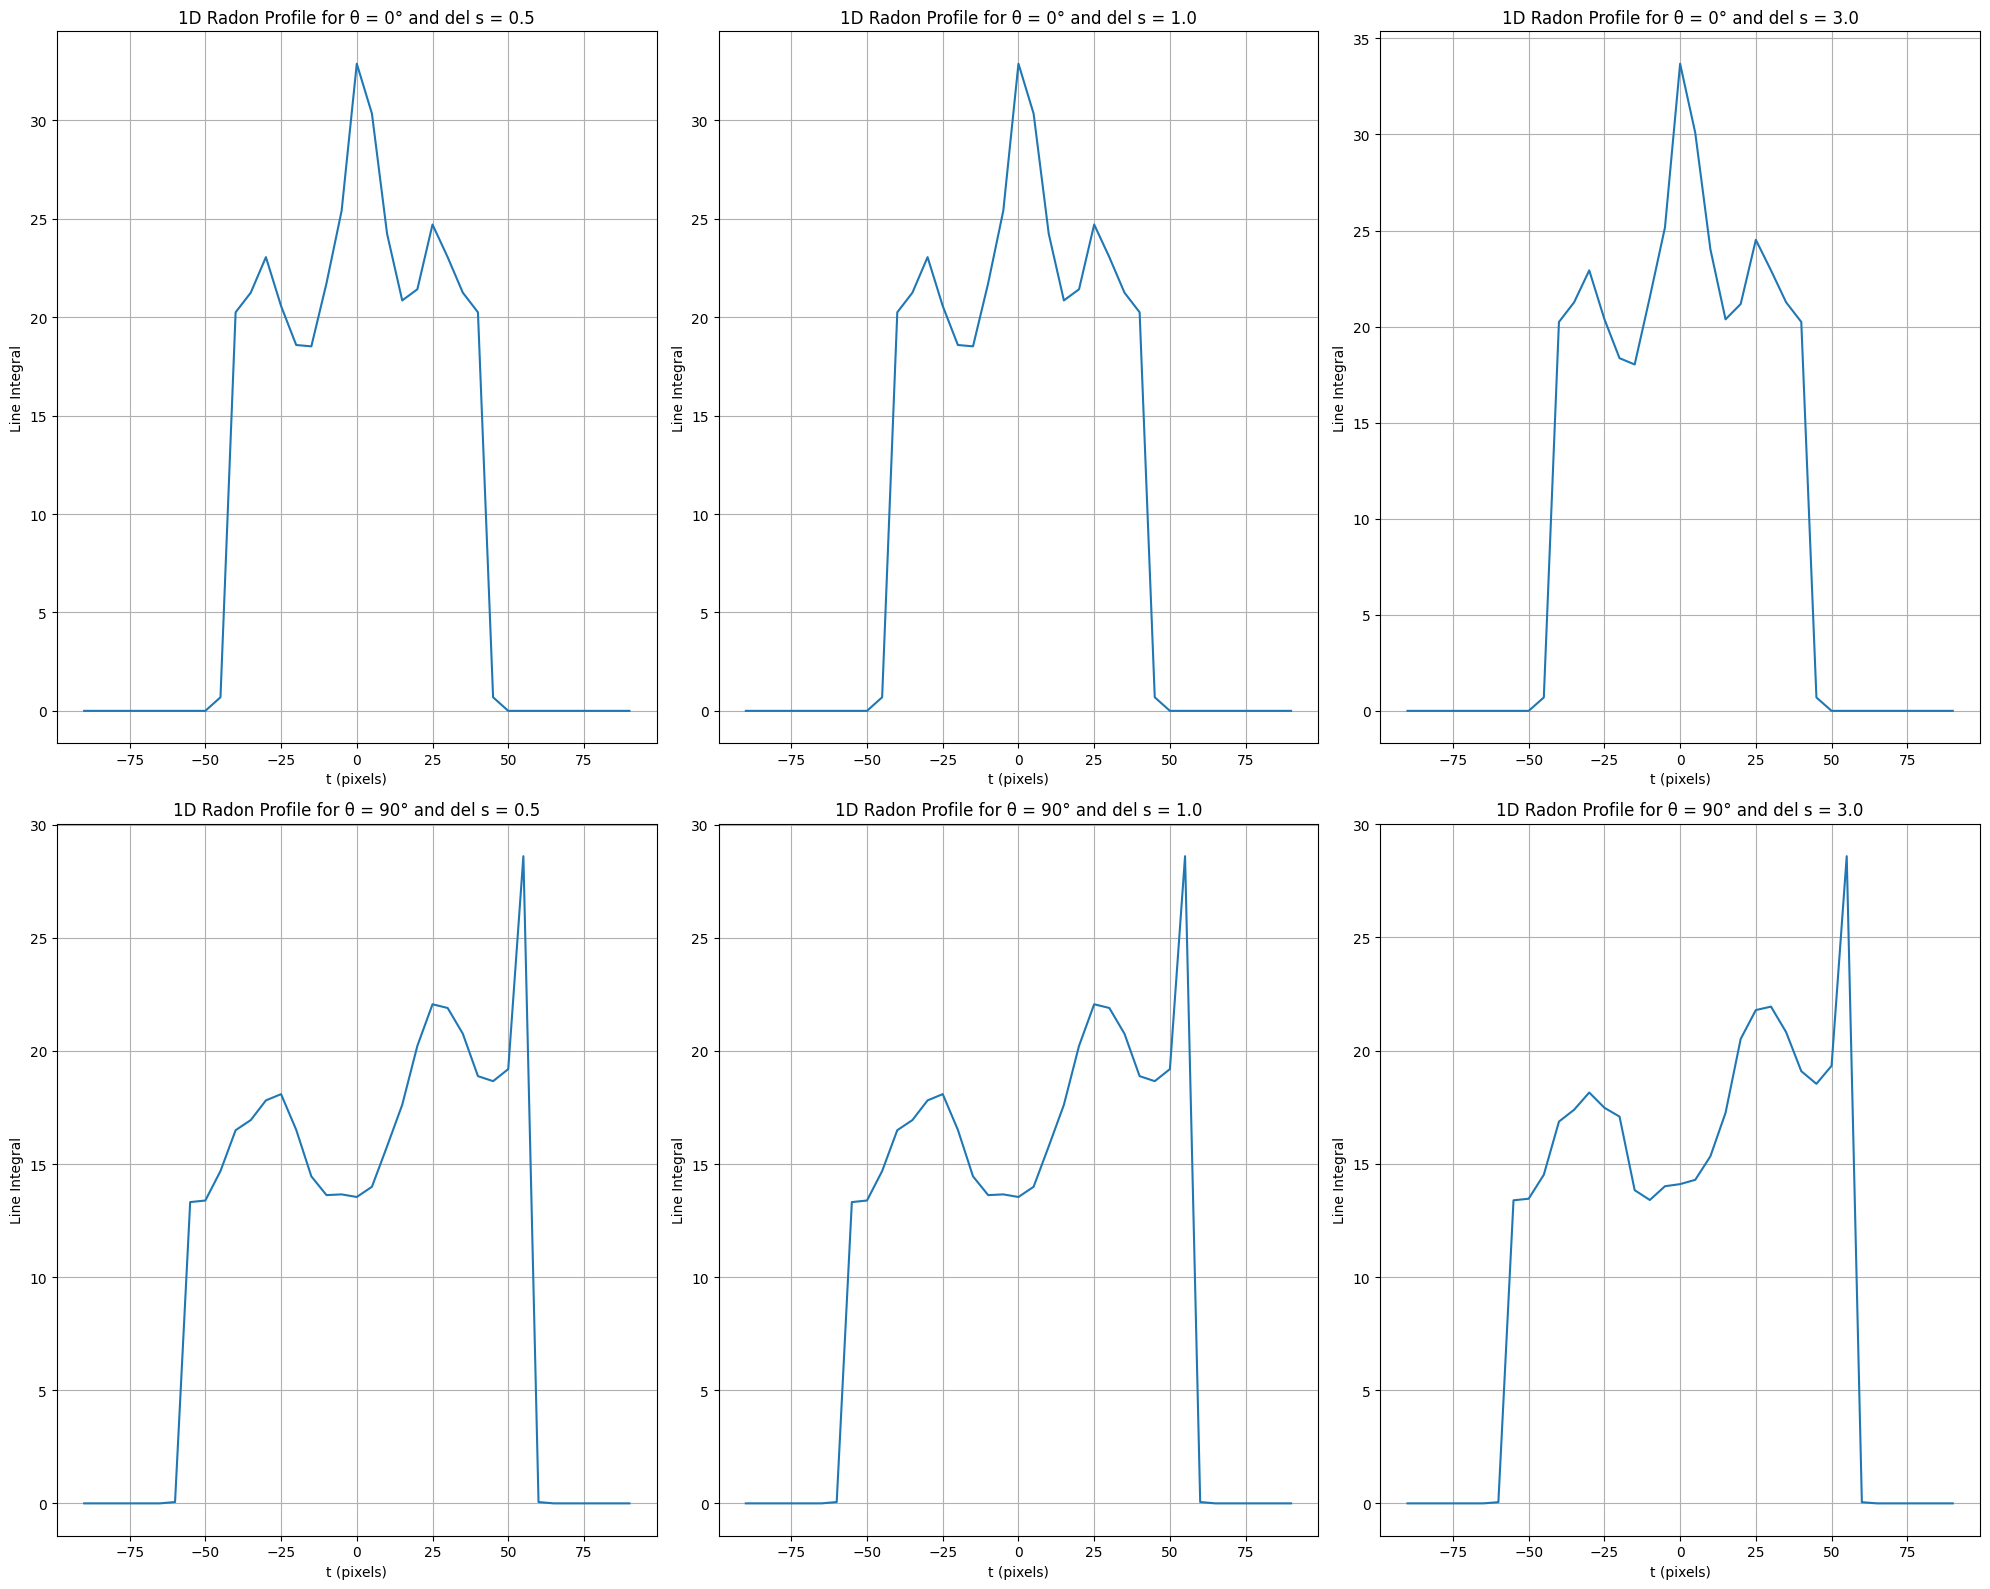

In [67]:
theta0_index = 0
theta90_index = 18 

fig, axs = plt.subplots(2, 3, figsize=(20, 16))

im1 = radon_results[0.5][:, theta0_index]  
axs[0][0].plot(t_vals, im1, label=f"del s = {0.5}")
axs[0][0].set_title("1D Radon Profile for θ = 0° and del s = 0.5")
axs[0][0].set_xlabel("t (pixels)")
axs[0][0].set_ylabel("Line Integral")
axs[0][0].grid(True)

im2 = radon_results[1.0][:, theta0_index] 
axs[0][1].plot(t_vals, im2, label=f"del s = {1.0}")
axs[0][1].set_title("1D Radon Profile for θ = 0° and del s = 1.0")
axs[0][1].set_xlabel("t (pixels)")
axs[0][1].set_ylabel("Line Integral")
axs[0][1].grid(True)

im3 = radon_results[3.0][:, theta0_index]  
axs[0][2].plot(t_vals, im3, label=f"del s = {3.0}")
axs[0][2].set_title("1D Radon Profile for θ = 0° and del s = 3.0")
axs[0][2].set_xlabel("t (pixels)")
axs[0][2].set_ylabel("Line Integral")
axs[0][2].grid(True)

im4 = radon_results[0.5][:, theta90_index] 
axs[1][0].plot(t_vals, im4, label=f"del s = {0.5}")
axs[1][0].set_title("1D Radon Profile for θ = 90° and del s = 0.5")
axs[1][0].set_xlabel("t (pixels)")
axs[1][0].set_ylabel("Line Integral")
axs[1][0].grid(True)

im5 = radon_results[1.0][:, theta90_index] 
axs[1][1].plot(t_vals, im5, label=f"del s = {1.0}")
axs[1][1].set_title("1D Radon Profile for θ = 90° and del s = 1.0")
axs[1][1].set_xlabel("t (pixels)")
axs[1][1].set_ylabel("Line Integral")
axs[1][1].grid(True)

im6 = radon_results[3.0][:, theta90_index]  
axs[1][2].plot(t_vals, im6, label=f"del s = {3.0}")
axs[1][2].set_title("1D Radon Profile for θ = 90° and del s = 3.0")
axs[1][2].set_xlabel("t (pixels)")
axs[1][2].set_ylabel("Line Integral")
axs[1][2].grid(True)

plt.tight_layout()
plt.show()



<b>Comparison between 1D function plots for the Radon-transform images for different $\theta$ and $\Delta$ s values:</b> <br><br>
Although the difference is not much, but the plots computed with $\Delta$ s = 0.5 appear smoothest which is because the integration along each line is sampled very finely. This yields a good approximation of the continuous integral and results in smooth 1D functions while the plots with $\Delta$ s = 3 appear roughest which is beacausethe integration along each line is sampled in a coarser manner, so the approximation of the line integral is less accurate and more prone to discretization noise effects. <br>
Further the plot with $\theta = 90^\circ$ seems comparatively smoother which may be because of difference in image variance along these two axes, thus we can infet that the image have the intensity variations in the image along the $\theta = 90^\circ$ direction are smaller.


(d)

In [68]:
def myXrayCTRadonTransform_2(f, delta_t=5, delta_theta=5, integration_step=0.5):

    t_values = np.arange(-90, 90 + delta_t, delta_t)
    theta_values = np.arange(0, 180, delta_theta)
    
    radon_transform = np.zeros((len(t_values), len(theta_values)))
    for j, theta in enumerate(theta_values):
        for i, t in enumerate(t_values):
            radon_transform[i, j] = myXrayIntegration(f, t, theta, del_s=integration_step)
    return radon_transform, t_values, theta_values


In [69]:
radon_fine, t_vals_fine, theta_vals_fine = myXrayCTRadonTransform_2(phantom, delta_t=1, delta_theta=1, integration_step=0.5)

radon_mod, t_vals_mod, theta_vals_mod = myXrayCTRadonTransform_2(phantom, delta_t=5, delta_theta=5, integration_step=0.5)

radon_coarse, t_vals_coarse, theta_vals_coarse = myXrayCTRadonTransform_2(phantom, delta_t=5, delta_theta=10, integration_step=0.5)


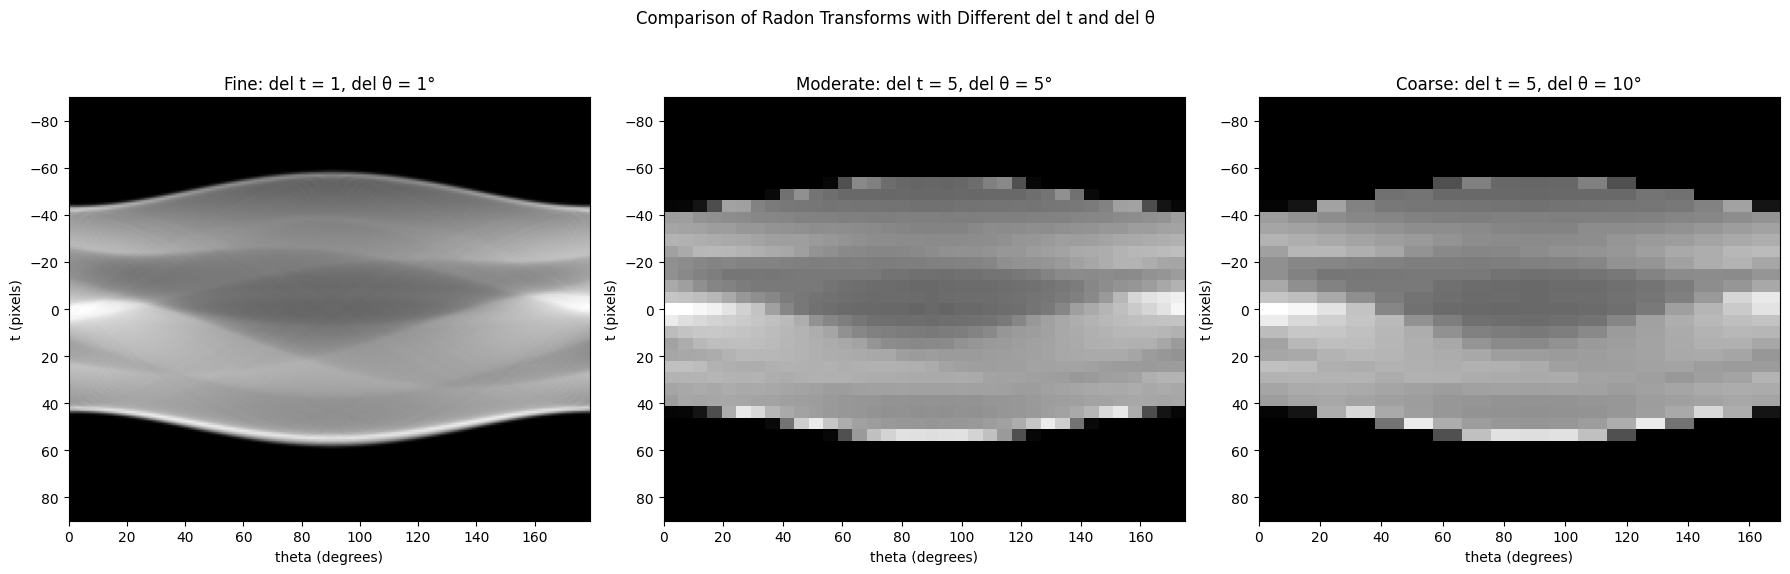

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

extent_fine   = [theta_vals_fine[0],   theta_vals_fine[-1],   t_vals_fine[-1],   t_vals_fine[0]]
extent_mod    = [theta_vals_mod[0],    theta_vals_mod[-1],    t_vals_mod[-1],    t_vals_mod[0]]
extent_coarse = [theta_vals_coarse[0], theta_vals_coarse[-1], t_vals_coarse[-1], t_vals_coarse[0]]

axs[0].imshow(radon_fine, cmap='gray', extent=extent_fine, aspect='auto')
axs[0].set_title("Fine: del t = 1, del θ = 1°")
axs[0].set_xlabel("theta (degrees)")
axs[0].set_ylabel("t (pixels)")

axs[1].imshow(radon_mod, cmap='gray', extent=extent_mod, aspect='auto')
axs[1].set_title("Moderate: del t = 5, del θ = 5°")
axs[1].set_xlabel("theta (degrees)")
axs[1].set_ylabel("t (pixels)")

axs[2].imshow(radon_coarse, cmap='gray', extent=extent_coarse, aspect='auto')
axs[2].set_title("Coarse: del t = 5, del θ = 10°")
axs[2].set_xlabel("theta (degrees)")
axs[2].set_ylabel("t (pixels)")

plt.suptitle("Comparison of Radon Transforms with Different del t and del θ")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<b>Designing of an Xray CT Scanner:</b><br><br>
Two primary parameters to be tuned for this purpose are $\Delta$ $\theta$ and $\Delta$ t, and it can be observed that smaller or finer values of these parameters lead to high resolution image (left side) but take more time while larger or coarser values provide low resolution image (right side) but computation time is also low. <br>
Thus based on this observation, I will avoid using very coarse sampling $(\Delta$ t >> detector resolution and $\Delta$ $\theta$ $\geq$ $10^\circ$) because these may lead to rough and very noisy sinograms and reconstruction artifacts. Therfore, I would choose moderate-to-fine sampling - ideally a $\Delta$ t that matches the detector's inherent resolution (more precisely typically around 1 pixel) and a $\Delta$ $\theta$ in the range of $1^\circ$ to $5^\circ$.

Justification for the choice: <br>
Fine sampling ($\delta$ t = 1, $\Delta$ $\theta$ = $1^\circ$) yields very smooth and detailed sinograms but also increases scan time, computational burden and radiation time. <br>
Moderate sampling ($\delta$ t = 5, $\Delta$ $\theta$ = $5^\circ$) provides a good compromise with acceptable image quality while controlling dose and data volume. <br>
Coarse angular sampling ($\delta$ t = 5, $\Delta$ $\theta$ = $10^\circ$) degrades image quality due to under-sampling, resulting in noticeable artifacts. <br>

(e)

<b>Designing a CT reconstruction software relying on ART: </b> <br> <br>
1. **Choosing the Scene Grid: Number of Pixels and Pixel Size:** <br>
I will prefer to choose a pixel size close to the physical detector resolution (matching or slightly oversampling), such that the scene grid is able to cover the entire object (and ideally some margin) so that all relevant features are included. For the number of pixels, I will maintain that the grid size is enough such that it covers the object completely, even including a small margin also.

2. **The effects of choosing $\Delta$ s >> 1 pixel width and $\Delta$ s << 1 pixel width:** <br>
When $\Delta$ s is much larger than the pixel width (i.e. typically $\Delta$ s >> 1), the sampling the ray is done very coarsely. Although the computation time may be fairly low, this will make the computed line integral miss some variations within each pixel, further, the integration jumps from one point to a point several pixels away, will lead to missing the gradual change in intensity between pixels while in case $\Delta$ s is much smaller than the pixel width (i.e. typically $\Delta$ s << 1), it will be case of high oversampling, although, it will lead to a much precise calculation of the line integral but it will also increase overall computational burden. Even after a certain point, further reduction in $\Delta$ s may not significantly improve the reconstruction accuracy (because the pixel model itself has a finite resolution), but it will slow down the reconstruction.

